$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$
# Part 6: YOLO - Objects Detection
<a id=part6></a>

In this part we will use an object detection architecture called YOLO (You only look once) to detect objects in images. We'll use an already trained model weights (v5) found here: https://github.com/ultralytics/yolov5

In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Load the YOLO model
model = torch.hub.load("ultralytics/yolov5", "yolov5s")
model.to(device)
# Images
img1 = 'imgs/DolphinsInTheSky.jpg'  
img2 = 'imgs/cat-shiba-inu-2.jpg' 

cpu


Using cache found in C:\Users\test0/.cache\torch\hub\ultralytics_yolov5_master


requirements: Ultralytics requirements ['gitpython>=3.1.30', 'pillow>=10.3.0', 'requests>=2.32.2', 'urllib3>=2.5.0 ; python_version > "3.8"'] not found, attempting AutoUpdate...


WARNING Retry 1/2 failed: Command 'pip install --no-cache-dir "gitpython>=3.1.30" "pillow>=10.3.0" "requests>=2.32.2" "urllib3>=2.5.0 ; python_version > "3.8"" ' returned non-zero exit status 2.


WARNING Retry 2/2 failed: Command 'pip install --no-cache-dir "gitpython>=3.1.30" "pillow>=10.3.0" "requests>=2.32.2" "urllib3>=2.5.0 ; python_version > "3.8"" ' returned non-zero exit status 2.


WARNING requirements:  Command 'pip install --no-cache-dir "gitpython>=3.1.30" "pillow>=10.3.0" "requests>=2.32.2" "urllib3>=2.5.0 ; python_version > "3.8"" ' returned non-zero exit status 2.


YOLOv5  2025-12-23 Python-3.8.12 torch-1.10.1 CPU



Fusing layers... 


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs


Adding AutoShape... 


## Inference with YOLO
<a id=part6_1></a>

You are provided with 2 images (img1 and img2).
**TODO**:
1. Detect objects using the YOLOv5 model for these 2 images.
2. Print the inference output with bounding boxes.
3. Look at the inference results and answer the question below.


inference output img 1:
image 1/1: 183x275 2 persons, 1 surfboard
Speed: 15.6ms pre-process, 156.3ms inference, 15.6ms NMS per image at shape (1, 3, 448, 640)
         xmin       ymin        xmax        ymax  confidence  class       name
0  100.278389  47.370987  187.863541  118.462662    0.903491      0     person
1   22.531363  20.887978  128.905212   92.257042    0.500972      0     person
2   85.617989  98.014679  139.018356  124.627907    0.367016     37  surfboard


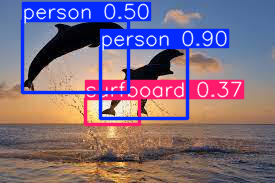

inference output img 2:
image 1/1: 750x750 2 cats, 1 dog
Speed: 15.7ms pre-process, 218.7ms inference, 1.8ms NMS per image at shape (1, 3, 640, 640)
         xmin        ymin        xmax        ymax  confidence  class name
0   11.568546  115.775024  312.757080  667.323669    0.655977     15  cat
1  363.715393  290.178528  750.000000  721.983826    0.509417     16  dog
2  311.190704  102.437622  595.031738  687.870605    0.391701     15  cat


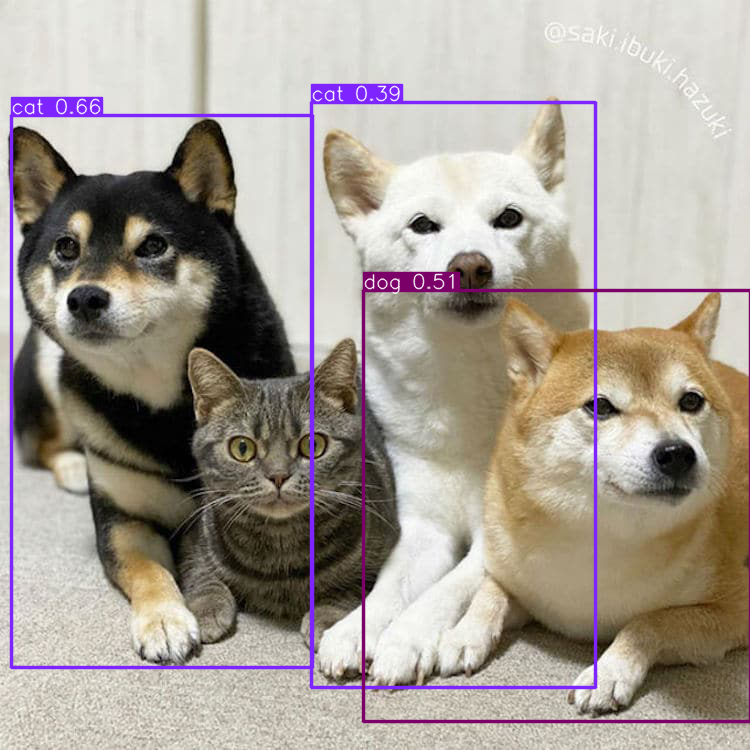

In [2]:
with torch.no_grad():
    #Detecting objects using YOLOv5S
    objs_img1 = model(img1)
    objs_img2 = model(img2)

    #Printing inference output1 with bounding boxes
    print('inference output img 1:')
    print(objs_img1)
    print(objs_img1.pandas().xyxy[0])
    objs_img1.show()

    #Printing inference output2 with bounding boxes
    print('inference output img 2:')
    print(objs_img2)
    print(objs_img2.pandas().xyxy[0])
    objs_img2.show()

### Question 1

Analyze the inference results of the 2 images. 
1. How well did the model detect the objects in the pictures? with what confidance?
2. What can possibly be the reason for the model failures? suggest methods to resolve that issue.
3. recall that we learned how to fool a model by adverserial attack (PGD), describe how you would attack an Object Detection model (such as YOLO).

In [3]:
#====
from cs236781.answers import display_answer
import hw2.answers
#====

display_answer(hw2.answers.part6_q1)


**1. Inference Analysis:**
* **Image 1 (Dolphins):** **Failure.** The model failed to identify the dolphins. Instead, it detected a "person" (0.90 confidence) and a "surfboard" (0.37).
* **Image 2 (Pets):** **Partial/Noisy Detection.** The model struggled with the overlapping animals. It misclassified the black dog as a "cat", and for the white dog, it outputted two conflicting boxes (one "dog", one "cat") on the same object.

**2. Reasons for Failure and Fixes:**
* **Unsupported Class (Dolphins):** The model maybe failed because Dolphin might **not be included in its training classes**. A neural network cannot predict a class it has no output neuron for. Instead, it matched the input features to the closest shapes it does know: a "surfboard" (smooth, in water) or a "person" (jumping action).
    * *Fix:* **Fine-Tuning.** We must retrain the final classification layer on a new dataset that explicitly contains the "Dolphin" class.
* **Occlusion/Overlap (Pets):** The dogs and cat are physically touching and overlapping. This causes two issues:
    1.  **Feature Mixing:** The convolutional features for the animals blend together, confusing the classifier (hence calling a dog a "cat").
    2.  **NMS Failure:** The Non-Maximum Suppression algorithm failed to remove the duplicate box on the white dog because the model gave them different labels (Cat vs Dog), so it treated them as two valid objects.
    * *Fix:* **Augmentation.** Retrain using "MixUp" or "Mosaic" augmentations (overlapping images) to force the model to handle occlusion better.

**3. Adversarial Attack on Object Detection:**
We can use a PGD attack, which is similar to what we learned for classification but with a different target.
* **Goal:** Instead of minimizing loss to *improve* accuracy, we want to **maximize** the loss to *destroy* detection.
* **Method:** We take the input image $x$ and add small noise. We perform **Gradient Ascent** on the "Objectness" score (the probability that a box contains an object).
* **Result:** By maximizing the loss of the objectness score, we force the model's confidence below the detection threshold. The bounding box will disappear, and the object will become "invisible" to the detector. Alternatively, we could attack the classification loss to force the model to misclassify the object (e.g., make a person look like a surfboard).


## Creative Detection Failures

<a id=part6_2></a>

Object detection pitfalls could be, for example: **occlusion** - when the objects are partially occlude, and thus missing important features, **model bias** - when a model learn some bias about an object, it could recognize it as something else in a different setup, and many others like **Deformation**, **Illumination conditions**, **Cluttered** or **textured background and blurring** due to moving objects.

**TODO**: Take pictures and that demonstrates 3 of the above object detection pitfalls, run inference and analyze the results.

image 1/1: 300x400 (no detections)
Speed: 0.0ms pre-process, 156.2ms inference, 0.0ms NMS per image at shape (1, 3, 480, 640)
Empty DataFrame
Columns: [xmin, ymin, xmax, ymax, confidence, class, name]
Index: []


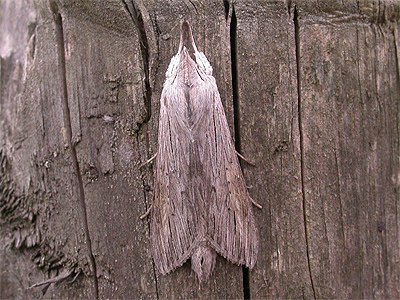

image 1/1: 192x204 (no detections)
Speed: 0.0ms pre-process, 203.2ms inference, 0.0ms NMS per image at shape (1, 3, 608, 640)
Empty DataFrame
Columns: [xmin, ymin, xmax, ymax, confidence, class, name]
Index: []


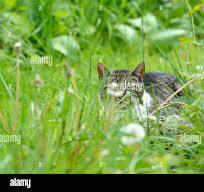

image 1/1: 159x318 1 car, 1 boat
Speed: 0.0ms pre-process, 125.0ms inference, 0.0ms NMS per image at shape (1, 3, 320, 640)
         xmin       ymin        xmax        ymax  confidence  class  name
0   76.960609  43.648521   84.001457   49.294674    0.467336      2   car
1  138.797104  45.091938  293.183350  121.072258    0.415132      8  boat


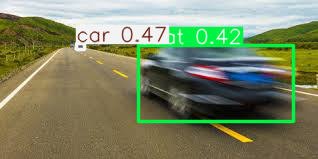

In [4]:
# You can change the images names in the code below, and add new ones

images = [
    "hw2/imgs/shark_moth_wood.jpg",
    "hw2/imgs/cat_grass.jpg",
    "hw2/imgs/speeding_car.jpg"
]

with torch.no_grad():
    for img in images:
        objs_img = model(img)
        print(objs_img)
        print(objs_img.pandas().xyxy[0])
        objs_img.show()

### Question 3

Analyize the results of the inference. 
1. How well did the model detect the objects in the pictures? explain.


In [5]:
display_answer(hw2.answers.part6_q3)



**1. Camouflage (Moth): Failure.**
* **Result:** No objects were detected.
* **Analysis:** The moth's texture matches the wood grain background. YOLO relies heavily on **edge detection** and **contrast** to propose regions of interest. Since the camouflage effectively removes the boundary between the object and the background, the model treats the moth as part of the tree bark.

**2. Occlusion (Cat in Grass): Failure.**
* **Result:** No objects were detected.
* **Analysis:** The tall grass breaks the cat's body into disjointed fragments. Convolutional Neural Networks look for specific **spatial hierarchies of features** (e.g., ears near eyes near a nose). When these features are visually separated, as they are hidden by grass, the model cannot combine them into a single valid "Cat" instance, dropping the confidence score below the detection threshold.

**3. Motion Blur (Speeding Car): Misclassification.**
* **Result:** The main speeding car was misclassified as a **"boat" (0.42)**. However, the model correctly detected the tiny car in the distance as a **"car" (0.47)**.
* **Analysis:** This highlights the model's dependency on sharp, high-frequency features. The motion blur smoothed out defining characteristics of the main car like **wheels and door handles**, leaving a smooth, elongated shape that the model interpreted as a boat hull. The distant car was detected because it was less blurred, preserving the sharp edges required for identification despite its small size.


## Bonus 
<a id=part6_3></a>

Try improving the model performance over poorly recognized images by changing them. 
Describe the manipulations you did to the pictures.

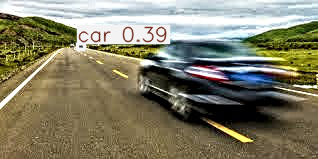

  name  confidence
0  car    0.391327


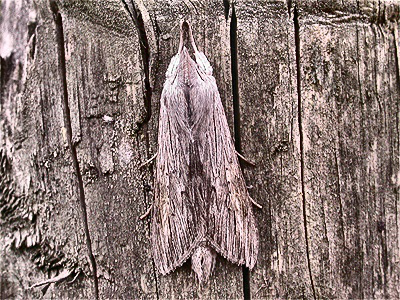

Empty DataFrame
Columns: [name, confidence]
Index: []


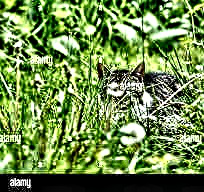

Empty DataFrame
Columns: [name, confidence]
Index: []


In [6]:
import cv2
import numpy as np

def sharpen(img):
    return cv2.detailEnhance(img, sigma_s=10, sigma_r=0.15)

def boost_contrast(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    l = clahe.apply(l)
    return cv2.cvtColor(cv2.merge((l,a,b)), cv2.COLOR_LAB2BGR)

img_car = cv2.imread('hw2/imgs/speeding_car.jpg')
if img_car is not None:
    cv2.imwrite('hw2/imgs/fixed_car.jpg', sharpen(img_car))

img_moth = cv2.imread('hw2/imgs/shark_moth_wood.jpg')
if img_moth is not None:
    cv2.imwrite('hw2/imgs/fixed_moth.jpg', boost_contrast(img_moth))

img_cat = cv2.imread('hw2/imgs/cat_grass.jpg')
if img_cat is not None:
    fixed = sharpen(boost_contrast(img_cat))
    cv2.imwrite('hw2/imgs/fixed_cat.jpg', fixed)

fixed_files = ['hw2/imgs/fixed_car.jpg', 'hw2/imgs/fixed_moth.jpg', 'hw2/imgs/fixed_cat.jpg']

for f in fixed_files:
    results = model(f)
    results.show()
    print(results.pandas().xyxy[0][['name', 'confidence']])

In [7]:
display_answer(hw2.answers.part6_bonus)


We attempted to improve detection using standard image processing techniques, but observed an interesting failure case:

1. **Sharpening (Motion Blur):** We used the detailEnhance function. Which boosts high-frequency details (like the wheels) that was smoothed out by the motion blur. we thought this would allow the model to recover the "Car" classification.
**Result** In reality, the model, which is sensitive to texture, likely got confused by the noise, preventing it from recognizing the underlying car geometry. **performance degraded**.

2. **Contrast (Moth):** We tried to boost contrast between the moth's wings and the wood, which we thought would make the object's boundaries distinct enough for the detector to propose a bounding box.
**Result:** While visually clearer to humans, the extreme contrast adjustment likely destroyed the subtle texture difference the model uses to identify biological forms, resulting in **no detection**.
 
3. **Occlusion (Cat):** We applied both **contrast enhancement and sharpening** to try and make the visible features (eyes, ears) to be noticed out from the grass.
**Result** No detection again, similar to both of the earlier attempts.
